# Comparison of predictive features between the single- and multi-center RPN signature
- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/2_feature_analysis.ipynb
- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature
- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3
- Raw data from center 3 is available upon reasonable request.

## Imports

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Load behavioral data

In [2]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

## Load the saved final multi-center model

In [3]:
# load the RPN-signature (trained on sample 1):
model_multi_center = joblib.load('../res/multi-center/finalized_model_combat_multi-center.joblib') 

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SelectKBest from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator ElasticNet from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.1 when u

### function to extract predictive weights

In [4]:
#get region names from an arbitrary timeseries file
ts = pd.read_csv('../data/bochum-sample/regional_timeseries/bochum-023_pumi-17-scrubbed.tsv').iloc[:,1:] 
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")

# function to extract predictive weights:
def get_weights(model, labels=labels, modules=modules):
    RES = np.zeros(int(len(labels)*(len(labels)-1)/2))

    featuremask = model.named_steps['fsel'].get_support()
    RES[featuremask] = model.named_steps['model'].coef_
    
    print(np.sum(model.named_steps['model'].coef_!=0))
    
    RES_MAT = vec_to_sym_matrix(RES, diagonal=np.repeat(0, len(labels)))
    return RES_MAT
    

### plot the predictive network

In [5]:
#plot.plot_matrix(get_weights(model_multi_center)!=0, labels, modules)

## Load the weights of the RPN-siganture

In [6]:
rpn_conns = pd.read_csv("../res/predictive_connections.csv")
rpn_conns['abs_weight'] = rpn_conns['weight'].abs()
rpn_conns = rpn_conns.sort_values('abs_weight', ascending=False)
rpn_conns = rpn_conns.reset_index()
rpn_conns

,index,Unnamed: 0,idx_A,idx_B,mod_A,mod_B,reg_A,reg_B,weight,abs_weight
0,15,15,88,95,3_VATTnet_SALnet_BG_THAL,3_VATTnet_SALnet_BG_THAL,PUT_p,STgyr_p,0.270232,0.270232
1,5,5,15,45,1_CER,5_FPnet_VISDN,CER5,FP,0.245274,0.245274
2,1,1,1,99,1_CER,3_VATTnet_SALnet_BG_THAL,CER6_p,PSMcor_p,-0.200617,0.200617
3,7,7,16,85,1_CER,6_MOTnet,R_CERCR2_a,MOTnet_l,0.149634,0.149634
4,14,14,82,114,6_MOTnet,8_VISnet,MOTnet_m,MVISnet_p,-0.102468,0.102468
5,20,20,121,122,8_VISnet,8_VISnet,LVISnet_DP,VVISnet_m,0.094911,0.094911
6,0,0,0,34,2_MEAN_GM,7_DMnet,aMEAN_GM,L_IPlob,-0.086423,0.086423
7,18,18,96,116,3_VATTnet_SALnet_BG_THAL,8_VISnet,CAUDN_v,LVISnet_p,0.085078,0.085078
8,12,12,67,118,4_LIMnet,8_VISnet,CAUDNH_NACC,PVISnet_vm,-0.072571,0.072571
9,13,13,68,84,4_LIMnet,6_MOTnet,COLsul,MOTnet_vl,-0.062491,0.062491


In [7]:
#create a similar table from the multi-center signsature
RES_MAT = get_weights(model_multi_center)

df = pd.DataFrame(RES_MAT, columns=labels, index=labels)

idx = np.transpose(np.nonzero(np.triu(RES_MAT, k=1)))
print("Number of predictive connections:" + str(len(idx)))

lab = labels
#mod = modules
# hack for visulaization order
mod = np.array(['2_MEAN_GM',
'1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER',
 '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '4_LIMnet', '4_LIMnet', '4_LIMnet',
 '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet',
 '4_LIMnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL', '8_VISnet', '8_VISnet',
 '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet',
 '8_VISnet', '8_VISnet', '8_VISnet'])

#hack: rename for visualization order

multi_center_conns = pd.DataFrame( {'idx_A': idx[:,0],
                   'reg_A': lab[np.array(idx[:,0])],
                   'mod_A': mod[np.array(idx[:,0])],
                   'idx_B': idx[:,1],
                   'reg_B': lab[np.array(idx[:,1])],
                   'mod_B': mod[np.array(idx[:,1])],
                   'multi-center': RES_MAT[np.nonzero(np.triu(RES_MAT, k=1))].flatten()})


#table.to_csv(global_vars._RES_PRED_CONN_)
multi_center_conns['abs_multi-center'] = multi_center_conns['multi-center'].abs()
#table = table.sort_values('abs_multi-center', ascending=False)
#table = table.reset_index()
multi_center_conns

31
Number of predictive connections:31


,idx_A,reg_A,mod_A,idx_B,reg_B,mod_B,multi-center,abs_multi-center
0,0,GlobSig,2_MEAN_GM,19,VMPFcor_p,7_DMnet,0.104911,0.104911
1,1,CER6_p,1_CER,99,PSMcor_p,3_VATTnet_SALnet_BG_THAL,-0.080330,0.080330
2,3,R_CERCR2_p,1_CER,82,MOTnet_m,6_MOTnet,-0.027575,0.027575
3,6,L_CERCR2_a,1_CER,56,L_IFsul,5_FPnet_VISDN,-0.039034,0.039034
4,9,CER7b_m,1_CER,107,PCcor.1,3_VATTnet_SALnet_BG_THAL,0.040663,0.040663
5,9,CER7b_m,1_CER,114,MVISnet_p,8_VISnet,0.071035,0.071035
6,14,CER6_d,1_CER,82,MOTnet_m,6_MOTnet,-0.064479,0.064479
7,15,CER5,1_CER,45,FP,5_FPnet_VISDN,0.103640,0.103640
8,16,R_CERCR2_a,1_CER,85,MOTnet_l,6_MOTnet,0.104155,0.104155
9,16,R_CERCR2_a,1_CER,114,MVISnet_p,8_VISnet,-0.114222,0.114222


### some table transformations

In [8]:
rpn_conns['single-study']=rpn_conns['weight']
rpn_conns['connectivity'] = rpn_conns.reg_A.str.cat(' - ' + rpn_conns.reg_B).values
#rpn_conns = rpn_conns.set_index('connectivity', drop=)


multi_center_conns['connectivity'] = multi_center_conns.reg_A.str.cat(' - ' + multi_center_conns.reg_B).values
#table = table.set_index('connectivity', drop=False)

allconns=rpn_conns.merge(multi_center_conns, how='outer').iloc[:, 2:]
rpnonly=allconns[~allconns.weight.isna()].copy()

rpnonly['connectivity'] = rpnonly.reg_A.str.cat(' - ' + rpnonly.reg_B).values
rpnonly['abs_multi-center'] = rpnonly['multi-center'].abs()
rpnonly = rpnonly.sort_values('abs_multi-center', ascending=False)
rpnonly = rpnonly.reset_index()

#pd.wide_to_long(rpnonly[['connectivity', 'wrpn', 'wmulticenter']], "w", i="connectivity", j='model')
rpnonly_melt = pd.melt(rpnonly[['connectivity', 'single-study', 'multi-center']], id_vars=['connectivity'],
                       value_vars=['single-study', 'multi-center'], var_name='model')

intersection = rpnonly.dropna()

intersection_melt = pd.melt(intersection[['connectivity', 'single-study', 'multi-center']], id_vars=['connectivity'],
                       value_vars=['single-study', 'multi-center'], var_name='model')

intersection_melt

,connectivity,model,value
0,R_CERCR2_a - MOTnet_l,single-study,0.149634
1,CER5 - FP,single-study,0.245274
2,CER6_p - PSMcor_p,single-study,-0.200617
3,PUT_p - STgyr_p,single-study,0.270232
4,R_CERCR2_a - MOTnet_l,multi-center,0.104155
5,CER5 - FP,multi-center,0.103640
6,CER6_p - PSMcor_p,multi-center,-0.080330
7,PUT_p - STgyr_p,multi-center,0.047596


## Plot shared connections

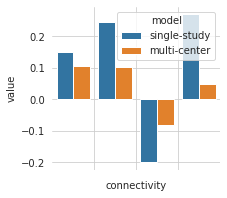

In [9]:
colors = ["tab:blue", "tab:orange"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(3, 3))
sns.barplot(data=intersection_melt, x='connectivity', y='value', hue='model')
plt.xticks(rotation=80)
plt.grid(True)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.xticks([x-0.5 for x in range(1,5, 1)] )
plt.savefig('../res/multi-center/barplot_combat.pdf')  

## Plot venn-diagrams

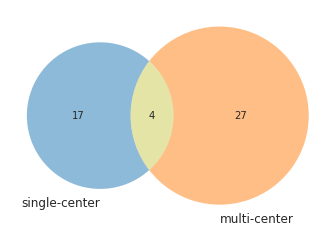

In [12]:
from matplotlib_venn import venn2

n_rpn = len(rpn_conns)
n_mc = len(multi_center_conns)
n_intersection = len(rpnonly.dropna())

# Use the venn2 function
v=venn2(subsets = (n_rpn - n_intersection,
                 n_mc - n_intersection,
                 n_intersection), set_labels = ('single-center', 'multi-center'))
v.get_patch_by_id('10').set_color('tab:blue')
v.get_patch_by_id('01').set_color('tab:orange')
v.get_patch_by_id('11').set_color('tab:olive')
v.get_patch_by_id('10').set_edgecolor('none')
v.get_patch_by_id('01').set_edgecolor('none')
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('10').set_alpha(0.5)
v.get_patch_by_id('01').set_alpha(0.5)
plt.savefig('../res/multi-center/venn_num_conns_combat.pdf')  

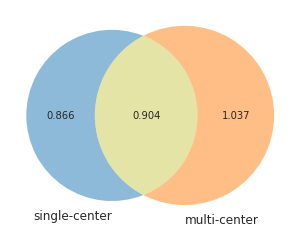

In [13]:
from matplotlib_venn import venn2

w_rpn = rpnonly['single-study'].abs().sum()
w_mc = multi_center_conns['multi-center'].abs().sum()
w_intersection = w_rpn - rpnonly.dropna()['single-study'].abs().sum()

# Use the venn2 function
v=venn2(subsets = (np.round(w_rpn - w_intersection, 3),
                 np.round(w_mc - w_intersection, 3),
                 np.round(w_intersection, 3)
                 ),
      set_labels = ('single-center', 'multi-center'))
v.get_patch_by_id('10').set_color('tab:blue')
v.get_patch_by_id('01').set_color('tab:orange')
v.get_patch_by_id('11').set_color('tab:olive')
v.get_patch_by_id('10').set_edgecolor('none')
v.get_patch_by_id('01').set_edgecolor('none')
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('10').set_alpha(0.5)
v.get_patch_by_id('01').set_alpha(0.5)
plt.savefig('../res/multi-center/venn_num_weights_combat.pdf')  

True


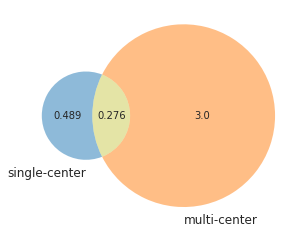

In [14]:
from matplotlib_venn import venn2

w_rpn = rpnonly['single-study'].abs().sum()
w_mc = multi_center_conns['multi-center'].abs().sum() 
w_intersection_rpn = rpnonly.dropna()['single-study'].abs().sum() / w_rpn
w_intersection_mc = rpnonly.dropna()['multi-center'].abs().sum() / w_mc
w_mc_norm = w_intersection_rpn * w_mc / w_intersection_mc

print(w_intersection_mc / w_mc == w_intersection_rpn / w_mc_norm)

# Use the venn2 function
v=venn2(subsets = (np.round((w_rpn - w_intersection) / w_rpn, 3),
                 np.round((w_mc_norm - w_intersection_rpn) / w_rpn, 0),
                 np.round(w_intersection_rpn / w_rpn, 3)
                 ),
      set_labels = ('single-center', 'multi-center'))
v.get_patch_by_id('10').set_color('tab:blue')
v.get_patch_by_id('01').set_color('tab:orange')
v.get_patch_by_id('11').set_color('tab:olive')
v.get_patch_by_id('10').set_edgecolor('none')
v.get_patch_by_id('01').set_edgecolor('none')
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('10').set_alpha(0.5)
v.get_patch_by_id('01').set_alpha(0.5)
plt.savefig('../res/multi-center/venn_num_weights_combat.pdf')  

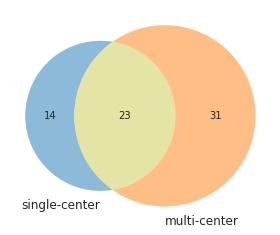

In [15]:
regs_rpn = len(np.unique(np.hstack((rpn_conns.reg_A.values, rpn_conns.reg_B.values)) )) # 37/122
regs_mc = len(np.unique(np.hstack((multi_center_conns.reg_A.values, multi_center_conns.reg_B.values)) )) #87/122
regs_union = len(np.unique(np.hstack((rpn_conns.reg_A.values, rpn_conns.reg_B.values,
           multi_center_conns.reg_A.values, multi_center_conns.reg_B.values)) ))
regs_intersection = regs_rpn + regs_mc - regs_union

v=venn2(subsets = (regs_rpn-regs_intersection,
                 regs_mc-regs_intersection,
                 regs_intersection
                 ),
      set_labels = ('single-center', 'multi-center'))
v.get_patch_by_id('10').set_color('tab:blue')
v.get_patch_by_id('01').set_color('tab:orange')
v.get_patch_by_id('11').set_color('tab:olive')
v.get_patch_by_id('10').set_edgecolor('none')
v.get_patch_by_id('01').set_edgecolor('none')
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('10').set_alpha(0.5)
v.get_patch_by_id('01').set_alpha(0.5)
plt.savefig('../res/multi-center/venn_num_regions_combat.pdf')  

## Create large-scale network level summaries

In [16]:
module_names = np.unique(mod)
# creeate modular matrix:
rpn_matrix_pos = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)
rpn_matrix_neg = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)

conns_rpn=pd.DataFrame(columns=['reg_A', 'reg_B', 'mod_A', 'mod_B', 'weight'])

for i in range(len(rpn_conns)):
    if rpn_conns['weight'][i] > 0:
        rpn_matrix_pos.loc[rpn_conns.mod_A[i], rpn_conns.mod_B[i]] += rpn_conns['weight'][i]
        rpn_matrix_pos.loc[rpn_conns.mod_B[i], rpn_conns.mod_A[i]] += rpn_conns['weight'][i]

        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'mod_A'] = rpn_conns.mod_A[i]
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'mod_B'] = rpn_conns.mod_B[i]
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'reg_A'] = rpn_conns.mod_A[i] + '_pos'
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'reg_B'] = rpn_conns.mod_B[i] + '_pos'
        
        if np.isnan(conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'weight']):
            conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'weight'] = rpn_conns['weight'][i]
        else:
            conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'weight'] += rpn_conns['weight'][i]
        
    if rpn_conns['weight'][i] < 0:
        rpn_matrix_neg.loc[rpn_conns.mod_A[i], rpn_conns.mod_B[i]] += rpn_conns['weight'][i]
        rpn_matrix_neg.loc[rpn_conns.mod_B[i], rpn_conns.mod_A[i]] += rpn_conns['weight'][i]
    
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'mod_A'] = rpn_conns.mod_A[i]
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'mod_B'] = rpn_conns.mod_B[i]
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'reg_A'] = rpn_conns.mod_A[i] + '_neg'
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'reg_B'] = rpn_conns.mod_B[i] + '_neg'
        if np.isnan(conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'weight']):
            conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'weight'] = rpn_conns['weight'][i]
        else:
            conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'weight'] += rpn_conns['weight'][i]

conns_rpn.to_csv('../res/multi-center/large-scale_conns_rpn_combat.csv')

In [17]:
module_names = np.unique(mod)
# creeate modular matrix:
mc_matrix_pos = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)
mc_matrix_neg = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)

conns_mc=pd.DataFrame(columns=['reg_A', 'reg_B','mod_A', 'mod_B', 'weight'])

for i in range(len(multi_center_conns)):
    if multi_center_conns['multi-center'][i] > 0:
        mc_matrix_pos.loc[multi_center_conns.mod_A[i], multi_center_conns.mod_B[i]] += multi_center_conns['multi-center'][i]
        mc_matrix_pos.loc[multi_center_conns.mod_B[i], multi_center_conns.mod_A[i]] += multi_center_conns['multi-center'][i]

        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'mod_A'] = multi_center_conns.mod_A[i]
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'mod_B'] = multi_center_conns.mod_B[i]
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'reg_A'] = multi_center_conns.mod_A[i] + '_pos'
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'reg_B'] = multi_center_conns.mod_B[i] + '_pos'
        
        if np.isnan(conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'weight']):
            conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'weight'] = multi_center_conns['multi-center'][i]
        else:
            conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'weight'] += multi_center_conns['multi-center'][i]
        
    if multi_center_conns['multi-center'][i] < 0:
        mc_matrix_neg.loc[multi_center_conns.mod_A[i], multi_center_conns.mod_B[i]] += multi_center_conns['multi-center'][i]
        mc_matrix_neg.loc[multi_center_conns.mod_B[i], multi_center_conns.mod_A[i]] += multi_center_conns['multi-center'][i]
    
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'mod_A'] = multi_center_conns.mod_A[i]
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'mod_B'] = multi_center_conns.mod_B[i]
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'reg_A'] = multi_center_conns.mod_A[i] + '_neg'
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'reg_B'] = multi_center_conns.mod_B[i] + '_neg'
        if np.isnan(conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'weight']):
            conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'weight'] = multi_center_conns['multi-center'][i]
        else:
            conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'weight'] += multi_center_conns['multi-center'][i]
        
conns_mc.to_csv('../res/multi-center/large-scale_conns_multi-center_combat.csv')     

## Plot them as matrices

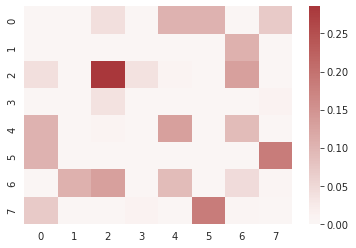

In [18]:
sns.heatmap(mc_matrix_pos.values, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_mc_pos_combat.pdf')  

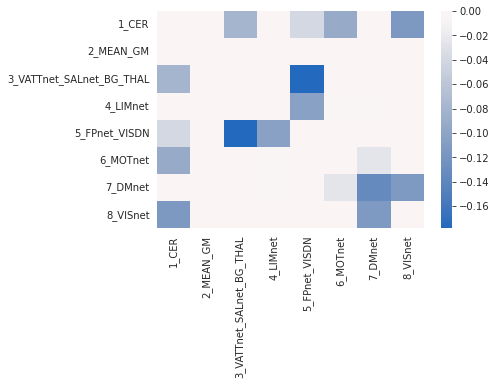

In [19]:
sns.heatmap(mc_matrix_neg, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_mc_neg_combat.pdf')  

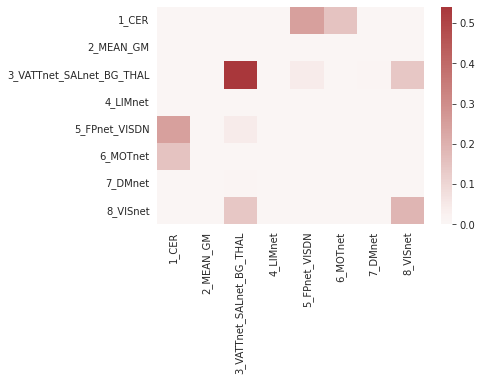

In [20]:
sns.heatmap(rpn_matrix_pos, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_rpn_pos_combat.pdf')  

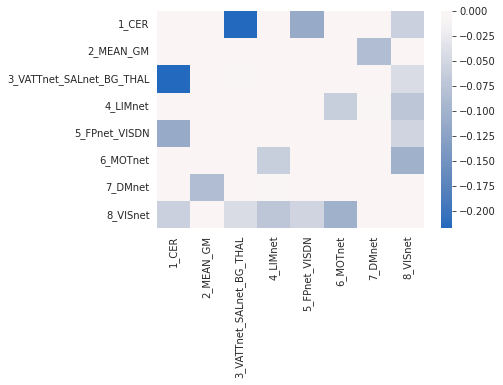

In [21]:
sns.heatmap(rpn_matrix_neg, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_rpn_neg_combat.pdf')  

## Plot predictive coefficients summarized in large-scale modules

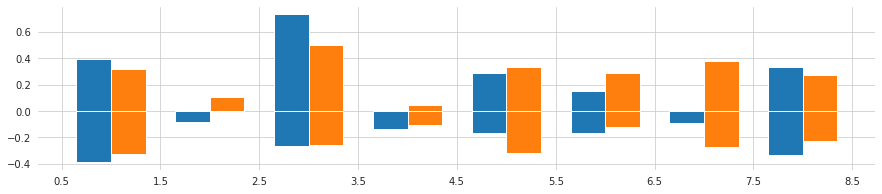

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 3)
x=np.array([1,2,3,4,5,6,7,8])
width=0.35
bar1pos=ax.bar(x - width/2, rpn_matrix_pos.sum(), width, label='single-center')
bar2pos=ax.bar(x + width/2, mc_matrix_pos.sum(), width, label='multi-center')

bar1neg=ax.bar(x - width/2, rpn_matrix_neg.sum(), width, label='single-center')
bar2neg=ax.bar(x + width/2, mc_matrix_neg.sum(), width, label='multi-center')
plt.grid(True)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.xticks([x-0.5 for x in range(1,10, 1)] )
plt.savefig('../res/multi-center/barplot_reg_combat.pdf') 

## Plot venn diagram for large-scale connectivity

In [23]:
np.sum(np.logical_and(np.triu((rpn_matrix_pos - rpn_matrix_neg).values) != 0,
                      np.triu((mc_matrix_pos - mc_matrix_neg).values) != 0))



12

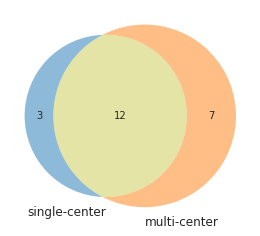

In [24]:
from matplotlib_venn import venn2

n_rpn = np.sum(np.triu((rpn_matrix_pos - rpn_matrix_neg).values) != 0)
n_mc = np.sum(np.triu((mc_matrix_pos - mc_matrix_neg).values) != 0)
n_intersection = np.sum(np.logical_and(np.triu((rpn_matrix_pos - rpn_matrix_neg).values) != 0,
                      np.triu((mc_matrix_pos - mc_matrix_neg).values) != 0))

# Use the venn2 function
v=venn2(subsets = (n_rpn - n_intersection,
                 n_mc - n_intersection,
                 n_intersection), set_labels = ('single-center', 'multi-center'))
v.get_patch_by_id('10').set_color('tab:blue')
v.get_patch_by_id('01').set_color('tab:orange')
v.get_patch_by_id('11').set_color('tab:olive')
v.get_patch_by_id('10').set_edgecolor('none')
v.get_patch_by_id('01').set_edgecolor('none')
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('10').set_alpha(0.5)
v.get_patch_by_id('01').set_alpha(0.5)
plt.savefig('../res/multi-center/venn_num_conns_combat_large-scale.pdf')  

## plot summed negative and positive contributions of large-scale networks

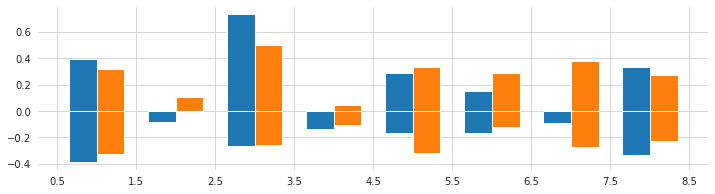

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 3)
x=np.array([1,2,3,4,5,6,7,8])
width=0.35
bar1pos=ax.bar(x - width/2, rpn_matrix_pos.sum(), width, label='single-center')
bar2pos=ax.bar(x + width/2, mc_matrix_pos.sum(), width, label='multi-center')

bar1neg=ax.bar(x - width/2, rpn_matrix_neg.sum(), width, label='single-center')
bar2neg=ax.bar(x + width/2, mc_matrix_neg.sum(), width, label='multi-center')
plt.grid(True)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.xticks([x-0.5 for x in range(1,10, 1)] )
plt.savefig('../res/multi-center/barplot_reg_combat.pdf') 

## Display all connectivities

In [26]:
pd.set_option("display.max_rows", None)
x=allconns[['idx_A', 'idx_B', 'mod_A', 'mod_B', 'reg_A', 'reg_B', 'single-study', 'multi-center']]
x['abs_mc'] = allconns['multi-center'].abs()
allconns

/tmp/ipykernel_181862/1798584007.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['abs_mc'] = allconns['multi-center'].abs()


,idx_A,idx_B,mod_A,mod_B,reg_A,reg_B,weight,abs_weight,single-study,connectivity,multi-center,abs_multi-center
0,88,95,3_VATTnet_SALnet_BG_THAL,3_VATTnet_SALnet_BG_THAL,PUT_p,STgyr_p,0.270232,0.270232,0.270232,PUT_p - STgyr_p,0.047596,0.047596
1,15,45,1_CER,5_FPnet_VISDN,CER5,FP,0.245274,0.245274,0.245274,CER5 - FP,0.103640,0.103640
2,1,99,1_CER,3_VATTnet_SALnet_BG_THAL,CER6_p,PSMcor_p,-0.200617,0.200617,-0.200617,CER6_p - PSMcor_p,-0.080330,0.080330
3,16,85,1_CER,6_MOTnet,R_CERCR2_a,MOTnet_l,0.149634,0.149634,0.149634,R_CERCR2_a - MOTnet_l,0.104155,0.104155
4,82,114,6_MOTnet,8_VISnet,MOTnet_m,MVISnet_p,-0.102468,0.102468,-0.102468,MOTnet_m - MVISnet_p,NaN,NaN
5,121,122,8_VISnet,8_VISnet,LVISnet_DP,VVISnet_m,0.094911,0.094911,0.094911,LVISnet_DP - VVISnet_m,NaN,NaN
6,0,34,2_MEAN_GM,7_DMnet,aMEAN_GM,L_IPlob,-0.086423,0.086423,-0.086423,aMEAN_GM - L_IPlob,NaN,NaN
7,96,116,3_VATTnet_SALnet_BG_THAL,8_VISnet,CAUDN_v,LVISnet_p,0.085078,0.085078,0.085078,CAUDN_v - LVISnet_p,NaN,NaN
8,67,118,4_LIMnet,8_VISnet,CAUDNH_NACC,PVISnet_vm,-0.072571,0.072571,-0.072571,CAUDNH_NACC - PVISnet_vm,NaN,NaN
9,68,84,4_LIMnet,6_MOTnet,COLsul,MOTnet_vl,-0.062491,0.062491,-0.062491,COLsul - MOTnet_vl,NaN,NaN


## Save finalized multi-center connections

In [27]:
multi_center_conns.to_csv('../res/multi-center/finalized_model_connections_combat.csv')

## predictive connections per center

In [28]:
from sklearn import preprocessing
X_harmonized = joblib.load('../res/multi-center/harmonized_features.joblib')
X_harmonized = preprocessing.RobustScaler().fit_transform(X_harmonized)

RES = np.zeros(int(len(labels)*(len(labels)-1)/2))

featuremask = model_multi_center.named_steps['fsel'].get_support()
RES[featuremask] = model_multi_center.named_steps['model'].coef_

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


*** PUT_p - STgyr_p study 1 ****************************************************
R=0.58
p_corr=0.00025
*** PUT_p - STgyr_p study 2 ****************************************************
R=0.28


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.04674
*** PUT_p - STgyr_p study 3 ****************************************************
R=-0.10


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.64354
*** CER5 - FP study 1 ****************************************************
R=0.57


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.00037
*** CER5 - FP study 2 ****************************************************
R=0.31


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.02975
*** CER5 - FP study 3 ****************************************************
R=0.25


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.14548
*** CER6_p - PSMcor_p study 1 ****************************************************
R=-0.49


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.99875
*** CER6_p - PSMcor_p study 2 ****************************************************
R=-0.27


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.94363
*** CER6_p - PSMcor_p study 3 ****************************************************
R=-0.13


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.70516
*** R_CERCR2_a - MOTnet_l study 1 ****************************************************
R=0.58


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.00037
*** R_CERCR2_a - MOTnet_l study 2 ****************************************************
R=0.17


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.14773
*** R_CERCR2_a - MOTnet_l study 3 ****************************************************
R=0.24


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p_corr=0.15098


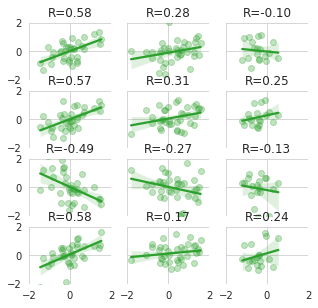

In [29]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

study_masks = {
    "study 1" : (df.study == 'bochum').values,
    "study 2" : (df.study == 'essen').values,
    "study 3" : (df.study == 'szeged').values
    #"study 1+2+3" : np.array([True] * len(y))
}

from mlxtend.evaluate import permutation_test

conns = ["PUT_p - STgyr_p", "CER5 - FP", "CER6_p - PSMcor_p", "R_CERCR2_a - MOTnet_l"]

fig, axs = plt.subplots(ncols=3, nrows=len(conns), figsize=(5,1.2*len(conns)), sharex=True, sharey=True)

#cols = ['tab:blue', 'tab:orange']

for row, cv in enumerate(conns):
    for col, study in enumerate(study_masks.keys()):
        
        coef = allconns[allconns.connectivity==cv]['multi-center'].values
        idx=np.argwhere(RES==coef).flatten()
        
        g=sns.regplot(y[study_masks[study]].values, X_harmonized[:,idx].flatten()[study_masks[study]], ax=axs[row, col],
                    scatter=True, scatter_kws={'alpha':0.3}, color='tab:green')
        g.set(xlabel=None) 
        axs[row, col].set_xlim([-2, 2])
        axs[row, col].set_ylim([-2, 2])
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['bottom'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        axs[row, col].grid(True)
        
        print('***', cv, study, '****************************************************')
                   
        corr = np.corrcoef(X_harmonized[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values)[0,1]
        axs[row, col].title.set_text("R={:.2f}".format(corr))
        print("R={:.2f}".format(corr))
        
        # takes some seconds
        p_corr = permutation_test(X_harmonized[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
        print("p_corr={:.5f}".format(p_corr))
   
        
plt.savefig('../res/multi-center/regplots_obs_conn_overlap.pdf')  

*** MOTnet_m - LVISnet_p study 1 ****************************************************
R=0.33
p_corr=0.02475
*** MOTnet_m - LVISnet_p study 2 ****************************************************
R=0.42
p_corr=0.00438
*** MOTnet_m - LVISnet_p study 3 ****************************************************
R=0.30
p_corr=0.11150
*** DMPFcor_ac - CAUDN_d study 1 ****************************************************
R=0.25
p_corr=0.06775
*** DMPFcor_ac - CAUDN_d study 2 ****************************************************
R=0.45
p_corr=0.00187
*** DMPFcor_ac - CAUDN_d study 3 ****************************************************
R=0.26
p_corr=0.14800
*** L_VLPFcor - SMgyr study 1 ****************************************************
R=-0.25
p_corr=0.92788
*** L_VLPFcor - SMgyr study 2 ****************************************************
R=-0.38
p_corr=0.99000
*** L_VLPFcor - SMgyr study 3 ****************************************************
R=-0.07
p_corr=0.58800
*** R_CERCR2_a - MVISnet_p study 1

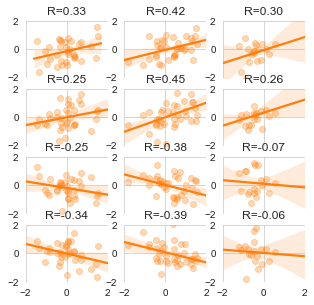

In [164]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

study_masks = {
    "study 1" : (df.study == 'bochum').values,
    "study 2" : (df.study == 'essen').values,
    "study 3" : (df.study == 'szeged').values
}

from mlxtend.evaluate import permutation_test

conns = ["MOTnet_m - LVISnet_p", "DMPFcor_ac - CAUDN_d", "L_VLPFcor - SMgyr", "R_CERCR2_a - MVISnet_p"]

fig, axs = plt.subplots(ncols=3, nrows=len(conns), figsize=(5,1.2*len(conns)), sharex=True, sharey=False)

#cols = ['tab:blue', 'tab:orange']

for row, cv in enumerate(conns):
    for col, study in enumerate(study_masks.keys()):
        
        coef = allconns[allconns.connectivity==cv]['multi-center'].values
        idx=np.argwhere(RES==coef).flatten()
        
        g=sns.regplot(y[study_masks[study]].values, X_harmonized[:,idx].flatten()[study_masks[study]], ax=axs[row, col],
                    scatter=True, scatter_kws={'alpha':0.3}, color='tab:orange')
        g.set(xlabel=None) 
        axs[row, col].set_xlim([-2, 2])
        axs[row, col].set_ylim([-2, 2])
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['bottom'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        axs[row, col].grid(True)
        
        print('***', cv, study, '****************************************************')
                   
        corr = np.corrcoef(X_harmonized[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values)[0,1]
        axs[row, col].title.set_text("R={:.2f}".format(corr))
        print("R={:.2f}".format(corr))
        
        # takes some seconds
        p_corr = permutation_test(X_harmonized[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
        print("p_corr={:.5f}".format(p_corr))
   
        
plt.savefig('../res/multi-center/regplots_obs_conn_mc.pdf')  

['MOTnet_m', 'MVISnet_p']
(7503,)
*** MOTnet_m - MVISnet_p study 1 ****************************************************
R=-0.52
p_corr=0.00125
['MOTnet_m', 'MVISnet_p']
(7503,)
*** MOTnet_m - MVISnet_p study 2 ****************************************************
R=-0.09
p_corr=0.58313
['MOTnet_m', 'MVISnet_p']
(7503,)
*** MOTnet_m - MVISnet_p study 3 ****************************************************
R=-0.20
p_corr=0.41663
['LVISnet_DP', 'VVISnet_m']
(7503,)
*** LVISnet_DP - VVISnet_m study 1 ****************************************************
R=0.52
p_corr=0.00162
['LVISnet_DP', 'VVISnet_m']
(7503,)
*** LVISnet_DP - VVISnet_m study 2 ****************************************************
R=-0.13
p_corr=0.42788
['LVISnet_DP', 'VVISnet_m']
(7503,)
*** LVISnet_DP - VVISnet_m study 3 ****************************************************
R=-0.03
p_corr=0.90350
['GlobSig', 'L_IPlob']
(7503,)
*** GlobSig - L_IPlob study 1 ****************************************************
R=-0.17


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


p_corr=0.33213
['GlobSig', 'L_IPlob']
(7503,)
*** GlobSig - L_IPlob study 2 ****************************************************
R=-0.20


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


p_corr=0.24163
['GlobSig', 'L_IPlob']
(7503,)
*** GlobSig - L_IPlob study 3 ****************************************************
R=-0.03


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


p_corr=0.88087
['CAUDN_v', 'LVISnet_p']
(7503,)
*** CAUDN_v - LVISnet_p study 1 ****************************************************
R=0.49
p_corr=0.00275
['CAUDN_v', 'LVISnet_p']
(7503,)
*** CAUDN_v - LVISnet_p study 2 ****************************************************
R=-0.00
p_corr=0.98175
['CAUDN_v', 'LVISnet_p']
(7503,)
*** CAUDN_v - LVISnet_p study 3 ****************************************************
R=0.02
p_corr=0.94900


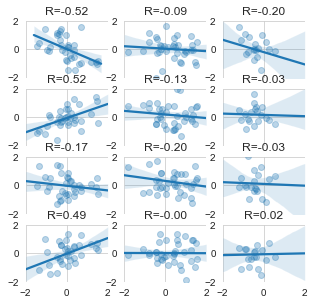

In [166]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

study_masks = {
    "study 1" : (df.study == 'bochum').values,
    "study 2" : (df.study == 'essen').values,
    "study 3" : (df.study == 'szeged').values
}


from mlxtend.evaluate import permutation_test

conns = ["MOTnet_m - MVISnet_p", "LVISnet_DP - VVISnet_m", "GlobSig - L_IPlob", "CAUDN_v - LVISnet_p"]

fig, axs = plt.subplots(ncols=3, nrows=len(conns), figsize=(5,1.2*len(conns)), sharex=True, sharey=False)

#cols = ['tab:blue', 'tab:orange']

for row, cv in enumerate(conns):
    for col, study in enumerate(study_masks.keys()):
        
        coef = allconns[allconns.connectivity==cv]['single-study'].values
        idx=np.argwhere(RES==coef).flatten()
        
        EX_MAT = pd.DataFrame(vec_to_sym_matrix(np.zeros(int(len(labels)*(len(labels)-1)/2)),
                                        diagonal=np.repeat(0, len(labels))),
                      columns=labels, index=labels)
        regs = cv.split(' - ')
        print(regs)
        EX_MAT.loc[regs[0], regs[1]] = EX_MAT.loc[regs[1], regs[0]] = 1
        vec_mask = sym_matrix_to_vec(EX_MAT.values, discard_diagonal=True)
        print(vec_mask.shape)
        idx=np.argwhere(vec_mask==1)
        
        g=sns.regplot(y[study_masks[study]].values, X_harmonized[:,idx].flatten()[study_masks[study]], ax=axs[row, col],
                    scatter=True, scatter_kws={'alpha':0.3}, color='tab:blue')
        g.set(xlabel=None) 
        axs[row, col].set_xlim([-2, 2])
        axs[row, col].set_ylim([-2, 2])
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['bottom'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        axs[row, col].grid(True)
        
        print('***', cv, study, '****************************************************')
                   
        corr = np.corrcoef(X_harmonized[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values)[0,1]
        axs[row, col].title.set_text("R={:.2f}".format(corr))
        print("R={:.2f}".format(corr))
        
        # takes some seconds
        p_corr = permutation_test(X_harmonized[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values,
                           func=lambda x, y: np.abs(np.corrcoef(x, y)[0,1]),
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
        print("p_corr={:.5f}".format(p_corr))
   
        
plt.savefig('../res/multi-center/regplots_obs_conn_rpn.pdf')  